### Mesonet EDA

We needed more data for our project so I used the Colorado State CoAgMET Data Api ([link](https://coagmet.colostate.edu/data/url-builder)) to download daily temperature and precipitation data from all of their stations. 

In [37]:
import numpy as np
import pandas as pd
import itertools as it
import functools as ft

from plotnine import *

In [58]:
runfile('../helpers.py')

In [3]:
data_file = '../../data/colorado_snow/daily_mesonet.csv'

station_data = pd.read_csv(data_file, skiprows=[1])
print(station_data.shape)
station_data.head()

(1043154, 31)


,Station,Date,Avg Temp,Max Temp,Max Temp Time,Min Temp,Min Temp Time,RH Max,RH Max Time,RH Min,...,ASCE Hourly ET,ASCE ETo,5cm Soil Max Temp,5cm Soil Max Temp Time,5cm Soil Min Temp,5cm Soil Min Temp Time,15cm Soil Max Temp,15cm Soil Max Temp Time,15cm Soil Min Temp,15cm Soil Min Temp Time
0,fcc01,01/01/2000,37.46,53.82,13:05,20.07,05:00,0.699,07:55,0.217,...,-999.0,-999.0,-999.0,NaN,-999.0,NaN,-999.0,NaN,-999.0,NaN
1,fcc01,01/02/2000,30.72,40.77,15:25,17.87,07:25,0.955,06:00,0.355,...,-999.0,-999.0,-999.0,NaN,-999.0,NaN,-999.0,NaN,-999.0,NaN
2,fcc01,01/03/2000,25.02,33.15,12:50,13.19,22:20,0.536,22:20,0.264,...,-999.0,-999.0,-999.0,NaN,-999.0,NaN,-999.0,NaN,-999.0,NaN
3,fcc01,01/04/2000,24.57,43.32,14:40,5.65,06:40,0.732,07:15,0.233,...,-999.0,-999.0,-999.0,NaN,-999.0,NaN,-999.0,NaN,-999.0,NaN
4,fcc01,01/05/2000,34.93,42.80,13:15,17.06,22:50,0.547,23:35,0.138,...,-999.0,-999.0,-999.0,NaN,-999.0,NaN,-999.0,NaN,-999.0,NaN


In [4]:
rain_df = station_data.loc[:, ['Station', 'Date', 'Precip', 'Solar Rad', 'Max Temp']].copy()
rain_df[['Precip', 'Solar Rad']] = rain_df[['Precip', 'Solar Rad']].replace(-999.0, np.nan)
rain_df.isna().sum(axis = 0)

Station           0
Date              0
Precip       491142
Solar Rad    497262
Max Temp          0
dtype: int64

Where are we missing those values? Across Stations or across time? Lets first check if the stations all have the same number of observations. 

/var/folders/hs/y8p4rwwn25n29b8gnr8l8xdh0000gn/T/ipykernel_74275/2496152363.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/mm/Documents/Data Science/Blog Posts/venv11/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.


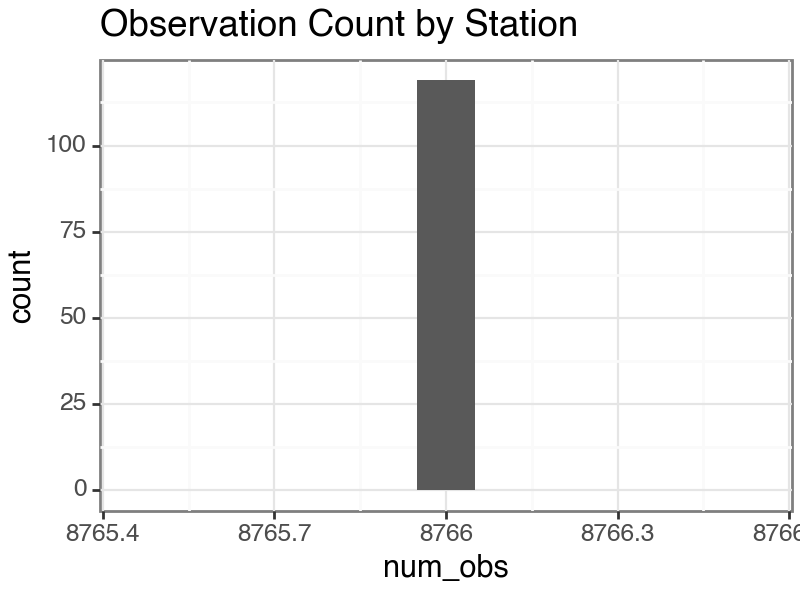

<Figure Size: (400 x 300)>

In [5]:
station_counts_df = rain_df.groupby(['Station']).apply(lambda df: pd.Series(dict(num_obs = df.shape[0])))

(ggplot(station_counts_df, aes(x = 'num_obs')) + 
 geom_histogram() + 
 theme_bw() +
 theme(figure_size=(4, 3)) +
 ggtitle('Observation Count by Station')
)

Ok so every station is at least accounted for. How many of them have missing values?

/var/folders/hs/y8p4rwwn25n29b8gnr8l8xdh0000gn/T/ipykernel_74275/2920290307.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


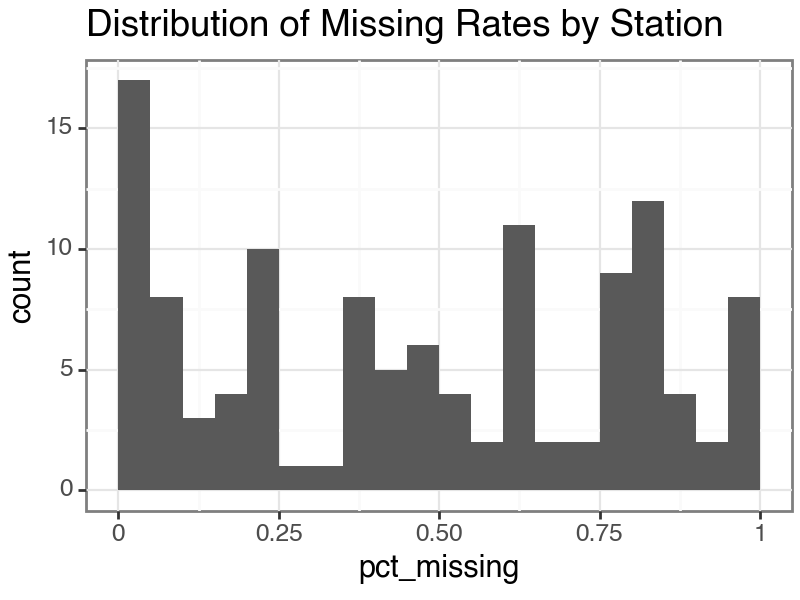

<Figure Size: (400 x 300)>

In [6]:
station_missing_counts_df = (
    rain_df.
    groupby(['Station']).
    apply(lambda df: pd.Series(dict(
        num_obs = df.shape[0],
        num_missing = df['Precip'].isnull().sum()))).
    reset_index().
    assign(pct_missing = lambda df: df['num_missing'] / df['num_obs'])
)

(ggplot(station_missing_counts_df, aes(x = 'pct_missing')) + 
 geom_histogram(binwidth = 0.05, boundary = 0) +
 theme_bw() +
 theme(figure_size = (4, 3)) +
 ggtitle('Distribution of Missing Rates by Station')
)

/var/folders/hs/y8p4rwwn25n29b8gnr8l8xdh0000gn/T/ipykernel_74275/216217770.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/mm/Documents/Data Science/Blog Posts/venv11/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.


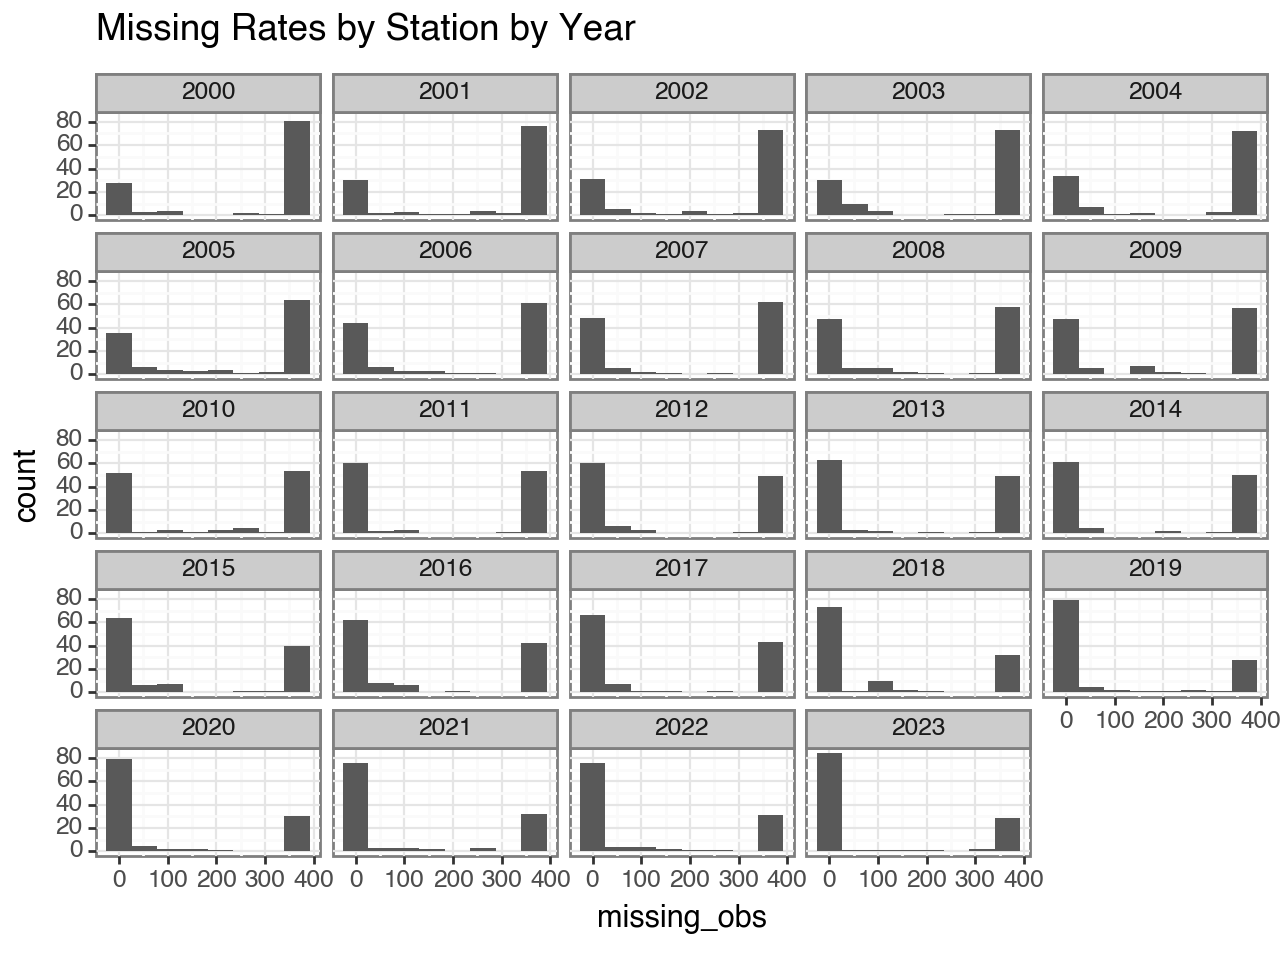

<Figure Size: (640 x 480)>

In [7]:
rain_df['date'] = pd.to_datetime(rain_df['Date'])
rain_df['year'] = rain_df['date'].dt.year
rain_df['month'] = rain_df['date'].dt.month

missing_obs_by_year = (
    rain_df.
    groupby(['Station', 'year']).
    apply(lambda df: pd.Series(dict(
        missing_obs = df['Precip'].isnull().sum()
    ))).
    reset_index().
    assign(pct_missing = lambda df: df['missing_obs'] / 365)
)

(ggplot(missing_obs_by_year, aes(x = 'missing_obs')) + 
 geom_histogram() + 
 facet_wrap('~year', nrow = 5) +
 theme_bw() +
 ggtitle('Missing Rates by Station by Year')
)

So we know that some stations never have observations and some are only missing historic data. So lets remove all the years where a station is missing more than 25% of its data. As you can see this 25% mark isn't really that important since most either have all their observations or none. 

In [8]:
rain_clean_df = (
    missing_obs_by_year.
    query('pct_missing < 0.25').
    loc[:, ['Station', 'year']].
    pipe(pd.merge, rain_df, on = ['Station', 'year'], how = 'inner')
)

print(rain_clean_df.shape)
print(rain_clean_df.loc[:, ['Station', 'year']].drop_duplicates().shape)

(532881, 8)
(1459, 2)


So we have 1,459 station-year combos to work with. In order to get more data I'm going to break the problem into predicting the next 30 days of rain from the previous 90. In order to do this I'm going to simply move every 30 days and ignore the months. 

In [9]:
rain_clean_df.head()

,Station,year,Date,Precip,Solar Rad,Max Temp,date,month
0,akr02,2005,01/01/2005,NaN,NaN,-999.0,2005-01-01,1
1,akr02,2005,01/02/2005,NaN,NaN,-999.0,2005-01-02,1
2,akr02,2005,01/03/2005,NaN,NaN,-999.0,2005-01-03,1
3,akr02,2005,01/04/2005,NaN,NaN,-999.0,2005-01-04,1
4,akr02,2005,01/05/2005,NaN,NaN,-999.0,2005-01-05,1


In [10]:
station_first_date = rain_clean_df.groupby(['Station']).date.min().to_frame(name = 'first_record').reset_index(names = 'Station')
station_first_date.head(10)

,Station,first_record
0,akr02,2005-01-01
1,alt01,2000-01-01
2,avn01,2000-01-01
3,bla01,2000-01-01
4,bnv01,2011-01-01
5,brg01,2003-01-01
6,brk01,2014-01-01
7,brl01,2000-01-01
8,brl02,2000-01-01
9,brl03,2008-01-01


In [11]:
rain_timeline_df = pd.merge(rain_clean_df, station_first_date, on = 'Station')
rain_timeline_df['day_of_year'] = rain_timeline_df['date'].dt.dayofyear
rain_timeline_df['day_since_first'] = (rain_timeline_df['date'] - rain_timeline_df['first_record']).dt.days
rain_timeline_df.head()

,Station,year,Date,Precip,Solar Rad,Max Temp,date,month,first_record,day_of_year,day_since_first
0,akr02,2005,01/01/2005,NaN,NaN,-999.0,2005-01-01,1,2005-01-01,1,0
1,akr02,2005,01/02/2005,NaN,NaN,-999.0,2005-01-02,1,2005-01-01,2,1
2,akr02,2005,01/03/2005,NaN,NaN,-999.0,2005-01-03,1,2005-01-01,3,2
3,akr02,2005,01/04/2005,NaN,NaN,-999.0,2005-01-04,1,2005-01-01,4,3
4,akr02,2005,01/05/2005,NaN,NaN,-999.0,2005-01-05,1,2005-01-01,5,4


In [12]:
def build_time_array(station_df, iv_length = 90, dv_length = 30):
    station_days = station_df.shape[0]
    startdays = np.arange(0, station_days - iv_length - dv_length, dv_length)
    df_list = list()
    for i, pos in enumerate(startdays):
        run_df = station_df.iloc[pos:(pos + iv_length + dv_length)].copy()
        run_df['label'] = np.concatenate((np.repeat('x', iv_length), np.repeat('y', dv_length)))
        run_df['station_run'] = i
        run_df['day_of_run'] = np.arange(run_df.shape[0])
        df_list.append(run_df)
    
    return pd.concat(df_list)

test_station_df = rain_timeline_df.query('Station == "egl01"')
print(test_station_df.shape)
test_data = build_time_array(test_station_df)
print(test_data.shape)

(1461, 11)
(5400, 14)


In [13]:
model_data_df = (
    rain_timeline_df.
    loc[:, ['Station', 'date', 'Precip']].
    sort_values(['Station', 'date']).
    groupby(['Station']).
    apply(build_time_array).
    reset_index(drop = True)
)

print(model_data_df.shape)
model_data_df.head(10)

(2084880, 6)


/var/folders/hs/y8p4rwwn25n29b8gnr8l8xdh0000gn/T/ipykernel_74275/3299936566.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Station,date,Precip,label,station_run,day_of_run
0,akr02,2005-01-01,NaN,x,0,0
1,akr02,2005-01-02,NaN,x,0,1
2,akr02,2005-01-03,NaN,x,0,2
3,akr02,2005-01-04,NaN,x,0,3
4,akr02,2005-01-05,NaN,x,0,4
5,akr02,2005-01-06,NaN,x,0,5
6,akr02,2005-01-07,NaN,x,0,6
7,akr02,2005-01-08,NaN,x,0,7
8,akr02,2005-01-09,NaN,x,0,8
9,akr02,2005-01-10,NaN,x,0,9


In [14]:
model_data_df['station_run'].value_counts()

station_run
0      13320
2      13320
3      13320
4      13320
5      13320
       ...  
281      720
280      720
278      720
277      720
288      720
Name: count, Length: 289, dtype: int64

0.7786347415678601


/var/folders/hs/y8p4rwwn25n29b8gnr8l8xdh0000gn/T/ipykernel_74275/2785370974.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


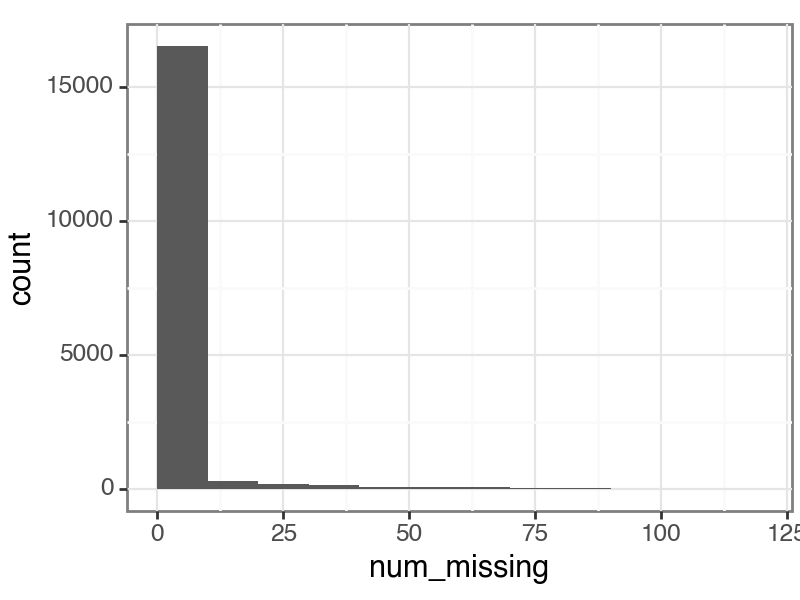

<Figure Size: (400 x 300)>

In [15]:
missing_runs = model_data_df.groupby(['Station', 'station_run']).apply(lambda df: pd.Series(dict(num_missing = df['Precip'].isnull().sum()))).reset_index()
print(np.mean(missing_runs['num_missing'] == 0))
(ggplot(missing_runs, aes(x = 'num_missing')) +
 geom_histogram(binwidth = 10, boundary = 0) +
 theme_bw() +
 theme(figure_size = (4, 3))
)

In [16]:
clean_run_data = (
    missing_runs.
    query('num_missing < 30').
    pipe(pd.merge, model_data_df, on = ['Station', 'station_run'], how = 'inner').
    fillna({'Precip': 0.0})
)

print(clean_run_data.shape)
clean_run_data.head()

(2040960, 7)


,Station,station_run,num_missing,date,Precip,label,day_of_run
0,akr02,1,11,2005-01-31,0.0,x,0
1,akr02,1,11,2005-02-01,0.0,x,1
2,akr02,1,11,2005-02-02,0.0,x,2
3,akr02,1,11,2005-02-03,0.0,x,3
4,akr02,1,11,2005-02-04,0.0,x,4


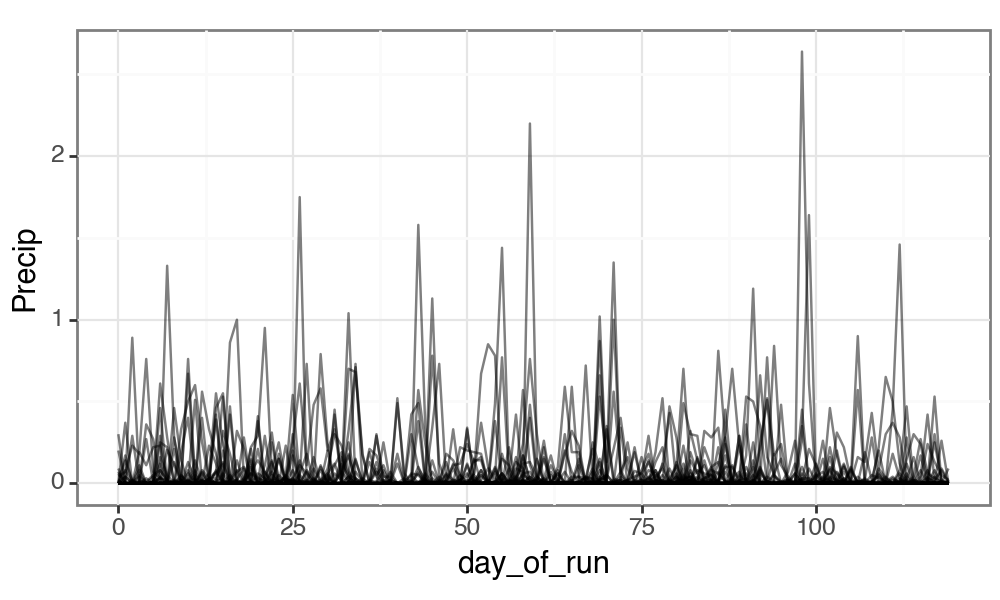

<Figure Size: (500 x 300)>

In [17]:
def sample_group(df, group_cols, n = 10):
    group_df = df[group_cols].drop_duplicates()
    group_df_sample = group_df.sample(n = n)
    select_df = pd.merge(df, group_df_sample, on = group_cols, how = 'inner')
    return select_df

clean_run_plot_df = sample_group(clean_run_data, group_cols = ['Station', 'station_run'], n = 50)
clean_run_plot_df['_group'] = clean_run_plot_df['Station'] + '-' + clean_run_plot_df['station_run'].astype("str")

(ggplot(clean_run_plot_df, aes(x = 'day_of_run', y = 'Precip')) +
 geom_line(aes(group = '_group'), alpha = .5) + 
 theme_bw() +
 theme(figure_size = (5, 3))
)

In [100]:
model_obs_df = clean_run_data.pivot(columns = ['day_of_run'], values = ['Precip'], index = ['Station', 'station_run'])
print(model_obs_df.shape)
model_obs_df.head(10)

(17008, 120)


Precip                                                 \
day_of_run             0     1     2    3     4     5     6     7     8     
Station station_run                                                         
akr02   1             0.00  0.00  0.00  0.0  0.00  0.00  0.00  0.00  0.00   
        2             0.00  0.00  0.00  0.0  0.00  0.00  0.00  0.00  0.00   
        3             0.00  0.00  0.00  0.0  0.13  0.00  0.00  0.00  0.00   
        4             0.00  0.00  0.00  0.0  0.00  0.03  0.04  0.05  0.00   
        5             0.00  0.00  0.11  0.8  0.06  0.00  0.00  0.00  0.00   
        6             0.33  0.00  0.00  0.0  0.35  0.26  0.00  0.00  0.00   
        7             0.00  0.00  0.00  0.0  0.00  0.00  0.00  0.00  0.00   
        8             0.00  0.00  0.00  0.0  0.00  0.00  0.00  0.00  0.00   
        9             0.01  0.00  0.00  0.0  0.00  0.00  0.02  0.00  0.00   
        10            0.00  0.02  0.02  0.0  0.00  0.00  0.00  0.00  0.04   

                           ...                                                 \
day_of_run            9    ...   110   111   112   113   114   115   116  117   
Station station_run        ...                                                  
akr02   1            0.00  ...  0.00  0.00  0.00  0.33  0.00  0.00  0.00  0.0   
        2            0.00  ...  0.67  0.00  0.00  0.00  0.00  0.01  0.09  0.0   
        3            0.11  ...  0.00  0.00  0.00  0.00  0.02  0.06  0.24  0.0   
        4            0.00  ...  0.00  0.00  0.00  1.00  0.00  0.00  0.56  0.0   
        5            0.02  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0   
        6            0.00  ...  0.00  0.05  0.00  0.34  0.00  0.00  0.00  0.0   
        7            0.00  ...  0.00  0.02  0.00  0.00  0.00  0.00  0.00  0.0   
        8            0.07  ...  0.00  0.00  0.03  0.00  0.00  0.00  0.00  0.0   
        9            0.00  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0   
        10           0.00  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0   

                                 
day_of_run            118   119  
Station station_run              
akr02   1            0.12  0.80  
        2            0.00  0.01  
        3            0.00  0.00  
        4            0.00  0.00  
        5            0.01  0.04  
        6            0.00  0.00  
        7            0.00  0.00  
        8            0.00  0.00  
        9            0.00  0.00  
        10           0.00  0.00  

[10 rows x 120 columns]

In [101]:
model_obs_df.columns = list(map(lambda x: 'day_' + str(x), model_obs_df.columns.droplevel()))
model_obs_df.reset_index(level = 0, names = 'Station', inplace = True)
model_obs_df.reset_index(names = 'station_run', inplace = True)
model_obs_df.head()

,station_run,Station,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_110,day_111,day_112,day_113,day_114,day_115,day_116,day_117,day_118,day_119
0,1,akr02,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.33,0.00,0.00,0.00,0.0,0.12,0.80
1,2,akr02,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,0.67,0.0,0.0,0.00,0.00,0.01,0.09,0.0,0.00,0.01
2,3,akr02,0.0,0.0,0.00,0.0,0.13,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.02,0.06,0.24,0.0,0.00,0.00
3,4,akr02,0.0,0.0,0.00,0.0,0.00,0.03,0.04,0.05,...,0.00,0.0,0.0,1.00,0.00,0.00,0.56,0.0,0.00,0.00
4,5,akr02,0.0,0.0,0.11,0.8,0.06,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.01,0.04


In [103]:
station_bitmap = BitmapEncoder()
station_map = station_bitmap.fit(X = model_obs_df['Station'])
station_map_df = station_bitmap.bitmap_df
print(station_map_df.shape)
station_map_df.head()

(111, 8)


,Station,Station_0,Station_1,Station_2,Station_3,Station_4,Station_5,Station_6
0,akr02,1,1,1,1,1,1,1
1,alt01,1,1,1,1,1,1,0
2,avn01,1,1,1,1,1,0,1
3,bla01,1,1,1,1,1,0,0
4,bnv01,1,1,1,1,0,1,1


In [104]:
model_obs_df = pd.merge(model_obs_df, station_map_df, on = 'Station')
print(model_obs_df.shape)

(17008, 129)


In [105]:
first_run_df = clean_run_data.query('day_of_run <= 0').copy()
first_run_df['day_of_year'] = first_run_df['date'].dt.day_of_year
first_run_df['year'] = first_run_df['date'].dt.year
first_run_df = first_run_df[['Station', 'station_run', 'day_of_year', 'year']]

model_obs_df = pd.merge(model_obs_df, first_run_df, on = ['Station', 'station_run'], how = 'left')
print(model_obs_df.shape)

(17008, 131)


In [111]:
columns = []
columns += filter_list(lambda x: x[:3] == 'day', model_obs_df.columns) ## this also catches day_of_year
columns += filter_list(lambda x: 'Station_' in x, model_obs_df.columns)
print(len(columns))

128


In [112]:
train_lgl = model_obs_df['year'] != 2023
train_data = model_obs_df.loc[train_lgl, columns]
train_data.to_parquet('rain_train_data.parquet')

test_data = model_obs_df.loc[~train_lgl, columns]
test_data.to_parquet('rain_test_data.parquet')

train_lgl.value_counts()

year
True     16319
False      689
Name: count, dtype: int64